In [48]:
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import (
	LogisticRegression, LogisticRegressionCV
)
from sklearn.metrics import (
	confusion_matrix, classification_report, f1_score,
	roc_curve, roc_auc_score, auc, RocCurveDisplay,
    brier_score_loss
)
from sklearn.model_selection import (
	train_test_split, RandomizedSearchCV, GridSearchCV, 
	cross_val_score, cross_val_predict, KFold, StratifiedKFold,
    RepeatedStratifiedKFold
)
from sklearn.preprocessing import (
	LabelEncoder, OneHotEncoder, StandardScaler,
	RobustScaler, QuantileTransformer,
)
import statsmodels.api as sm


SEED = 123
TEST_SIZE = 0.3

In [2]:
with open(Path('../data/df.pkl'), 'rb') as f:
    df = pickle.load(f)

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   pid                   148 non-null    object  
 1   study                 148 non-null    object  
 2   sample_id             148 non-null    object  
 3   class                 148 non-null    category
 4   age_years             148 non-null    float64 
 5   gender                148 non-null    category
 6   smoking_status        148 non-null    category
 7   packyears             148 non-null    float64 
 8   artery_number_5       148 non-null    int64   
 9   artery_volume_5       148 non-null    float64 
 10  artery_tortuosity_5   148 non-null    float64 
 11  artery_number_10      148 non-null    int64   
 12  artery_volume_10      148 non-null    float64 
 13  artery_tortuosity_10  148 non-null    float64 
 14  artery_number_15      148 non-null    int64   
 15  artery

,pid,study,sample_id,class,age_years,gender,smoking_status,packyears,artery_number_5,artery_volume_5,...,artery_tortuosity_15,vein_number_5,vein_volume_5,vein_tortuosity_5,vein_number_10,vein_volume_10,vein_tortuosity_10,vein_number_15,vein_volume_15,vein_tortuosity_15
0,2008-420,Cooper,420-1,Malignant,65.0,M,former,5.0,1,0.005662,...,1.00000,1,0.013388,1.00000,1,0.021113,1.00000,1,0.034588,1.02139
1,03745-2,PLuSS,LS15-0098,Benign,69.4,M,former,41.0,0,0.001250,...,1.02196,0,0.000000,1.00000,1,0.055875,1.00000,3,0.111875,1.00000
2,03533-3,PLuSS,LS15-0162,Benign,66.5,F,former,60.0,1,0.034375,...,1.23261,0,0.000000,1.00000,1,0.032750,1.00000,2,0.091125,1.41931
3,03336-8,PLuSS,LS14-0337,Benign,69.6,M,former,75.0,1,0.014500,...,1.03730,2,0.038750,1.03580,4,0.106625,1.03850,9,0.262000,1.04822
4,03244-8,PLuSS,LS15-0063,Benign,70.4,M,former,37.0,4,0.255750,...,1.17149,5,0.388542,1.13853,10,0.520625,1.10964,15,0.892933,1.08346


In [3]:
demo_cols = ['age_years', 'gender', 'smoking_status', 'packyears']
artery_cols = list(df.filter(regex='artery_', axis=1).columns)
vein_cols =   list(df.filter(regex='vein_',   axis=1).columns)
all_features = demo_cols + artery_cols + vein_cols

X = df.loc[:, all_features]

le = LabelEncoder()
y = le.fit_transform(df.loc[:, 'class'])

for i, label in enumerate(le.classes_):
    print(f"{i} = {label}")

y

0 = Benign
1 = Malignant


array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0])

# Train/Test Approach

In [4]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)

In [5]:
# Categorical

ohe = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)

X_cat_tr = pd.DataFrame(
    ohe.fit_transform(X_tr.select_dtypes('category')),
    index=X_tr.index,
    columns=ohe.get_feature_names_out()
)

X_cat_te = pd.DataFrame(
    ohe.fit_transform(X_te.select_dtypes('category')),
    index=X_te.index,
    columns=ohe.get_feature_names_out()
)


# Numeric
scaler = StandardScaler()

X_num_tr = pd.DataFrame(
    scaler.fit_transform(X_tr.select_dtypes(['int', 'float'])),
    index=X_tr.index,
    columns=X_tr.select_dtypes(['int', 'float']).columns
)

X_num_te = pd.DataFrame(
    scaler.transform(X_te.select_dtypes(['int', 'float'])),
    index=X_te.index,
    columns=X_te.select_dtypes(['int', 'float']).columns
)

Xp_tr = pd.concat([X_cat_tr, X_num_tr], axis=1)
Xp_te = pd.concat([X_cat_te, X_num_te], axis=1)

print(f"Shape(train): {Xp_tr.shape}\nShape(test): {Xp_te.shape}")
Xp_tr.head()

Shape(train): (103, 22)
Shape(test): (45, 22)


,gender_M,smoking_status_former,age_years,packyears,artery_number_5,artery_volume_5,artery_tortuosity_5,artery_number_10,artery_volume_10,artery_tortuosity_10,...,artery_tortuosity_15,vein_number_5,vein_volume_5,vein_tortuosity_5,vein_number_10,vein_volume_10,vein_tortuosity_10,vein_number_15,vein_volume_15,vein_tortuosity_15
53,1.0,1.0,-0.333474,0.222065,-0.840531,-0.593044,-0.579218,-0.648643,-0.677647,-0.809787,...,-0.903001,-0.653706,-0.352061,0.345673,-0.652965,-0.467049,-0.169009,-0.410321,-0.548741,1.119312
19,1.0,1.0,0.849212,-0.466482,0.180999,0.718436,-0.310359,0.074934,0.382382,-0.561598,...,-0.643161,-0.910697,-0.569273,-0.294839,-0.520049,-0.432649,-0.395586,-0.163649,-0.275604,-0.661644
38,0.0,0.0,0.915842,-0.595585,-0.840531,-0.542250,-0.004270,-0.407451,-0.111597,1.367383,...,0.534424,0.374259,0.408626,-0.505027,0.676193,0.178520,-0.436323,0.165246,-0.092385,0.147801
120,0.0,1.0,0.399458,-0.724687,-0.840531,-0.628279,-0.579218,-0.769240,-0.725954,-0.822673,...,-1.108695,-0.910697,-0.598087,0.290817,-0.652965,-0.658619,-0.038213,-0.821440,-0.713526,-0.287473
23,0.0,1.0,0.416115,-1.327165,-0.840531,-0.628279,-0.579218,-0.889836,-0.726149,-0.822673,...,-0.621532,-0.653706,-0.565284,-0.733975,-0.652965,-0.685397,-0.922639,-0.574768,-0.640038,-0.856368


In [6]:
demo_cols_enc = ['age_years', 'gender_M', 'smoking_status_former', 'packyears']

X_demo_tr, X_demo_te = Xp_tr.loc[:, demo_cols_enc], Xp_te.loc[:, demo_cols_enc]
X_arte_tr, X_arte_te = Xp_tr.loc[:, artery_cols], Xp_te.loc[:, artery_cols]
X_vein_tr, X_vein_te = Xp_tr.loc[:, vein_cols], Xp_te.loc[:, vein_cols]
X_all_tr = pd.concat([X_demo_tr, X_arte_tr, X_vein_tr], axis=1)
X_all_te = pd.concat([X_demo_te, X_arte_te, X_vein_te], axis=1)

In [7]:
# DEFINE MODEL
logit_cv = LogisticRegressionCV(
    Cs=200, 
    fit_intercept=True,
    cv=5,
    penalty='l1',
    solver='liblinear'
)

# INIT PREDICTIONS AND COEF
predictions = pd.DataFrame()
coefficients = pd.DataFrame()

# DEMO
# ---- Fit and predict
logit_cv.fit(X_demo_tr, y_tr)
temp_predictions = pd.DataFrame(logit_cv.predict_proba(X_demo_te)[:, 1], columns=['Demo'], index=X_demo_te.index)
temp_coef = pd.DataFrame({'Demo': logit_cv.coef_.squeeze()}, index=logit_cv.feature_names_in_)
# ---- Combine
predictions = pd.concat([predictions, temp_predictions], axis=1)
coefficients = pd.concat([coefficients, temp_coef], axis=1)

# ARTERY
# ---- Fit and predict
logit_cv.fit(X_arte_tr, y_tr)
temp_predictions = pd.DataFrame(logit_cv.predict_proba(X_arte_te)[:, 1], columns=['Artery'], index=X_arte_te.index)
temp_coef = pd.DataFrame({'Artery': logit_cv.coef_.squeeze()}, index=logit_cv.feature_names_in_)
# ---- Combine
predictions = pd.concat([predictions, temp_predictions], axis=1)
coefficients = pd.concat([coefficients, temp_coef], axis=1)

# VEIN
# ---- Fit and predict
logit_cv.fit(X_vein_tr, y_tr)
temp_predictions = pd.DataFrame(logit_cv.predict_proba(X_vein_te)[:, 1], columns=['Vein'], index=X_vein_te.index)
temp_coef = pd.DataFrame({'Vein': logit_cv.coef_.squeeze()}, index=logit_cv.feature_names_in_)
# ---- Combine
predictions = pd.concat([predictions, temp_predictions], axis=1)
coefficients = pd.concat([coefficients, temp_coef], axis=1)

# ALL
# ---- Fit and predict
logit_cv.fit(X_all_tr, y_tr)
temp_predictions = pd.DataFrame(logit_cv.predict_proba(X_all_te)[:, 1], columns=['All'], index=X_all_te.index)
temp_coef = pd.DataFrame({'All': logit_cv.coef_.squeeze()}, index=logit_cv.feature_names_in_)
# ---- Combine
predictions = pd.concat([predictions, temp_predictions], axis=1)
coefficients = pd.concat([coefficients, temp_coef], axis=1)

# GROUND TRUTH
predictions = pd.concat([predictions, pd.Series(y_te, name='GroundTruth', index=X_vein_te.index)], axis=1)

# EXPORT AND SHOW
predictions.to_csv('../output/logit_predictions.csv', index=False)
predictions.round(3).head()

C:\Users\qaust\miniconda3\envs\stats\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\qaust\miniconda3\envs\stats\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\qaust\miniconda3\envs\stats\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\qaust\miniconda3\envs\stats\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\qaust\miniconda3\envs\stats\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\qaust\miniconda3\envs\stats\lib\site-packages\sklearn\svm\_base.py:1244

,Demo,Artery,Vein,All,GroundTruth
87,0.472,0.909,0.588,0.854,1
125,0.454,0.873,0.619,0.756,1
124,0.420,0.989,0.720,0.967,1
103,0.524,0.572,0.502,0.447,1
42,0.598,0.232,0.446,0.336,0


In [8]:
coefficients

,Demo,Artery,Vein,All
age_years,-0.418877,NaN,NaN,-0.202189
gender_M,0.000000,NaN,NaN,0.000000
smoking_status_former,0.000000,NaN,NaN,0.000000
packyears,0.000000,NaN,NaN,-0.254030
artery_number_5,NaN,2.110623,NaN,1.038147
artery_volume_5,NaN,0.000000,NaN,0.000000
artery_tortuosity_5,NaN,0.000000,NaN,0.000000
artery_number_10,NaN,0.000000,NaN,0.000000
artery_volume_10,NaN,0.000000,NaN,0.000000
artery_tortuosity_10,NaN,-0.075742,NaN,0.000000


In [9]:
nonzero_coefs = coefficients[np.abs(coefficients) > 0].dropna(how='all')
nonzero_coefs.to_csv('../output/nonzero_coefs_regularized.csv', index=True)
nonzero_coefs

,Demo,Artery,Vein,All
age_years,-0.418877,NaN,NaN,-0.202189
packyears,NaN,NaN,NaN,-0.254030
artery_number_5,NaN,2.110623,NaN,1.038147
artery_tortuosity_10,NaN,-0.075742,NaN,NaN
artery_number_15,NaN,-0.766569,NaN,NaN
artery_tortuosity_15,NaN,0.102573,NaN,NaN
vein_number_5,NaN,NaN,0.236858,NaN
vein_volume_15,NaN,NaN,0.121143,0.303282


In [10]:
remaining_demo = coefficients.loc[np.abs(coefficients['Demo']) > 0, 'Demo'].index
remaining_arte = coefficients.loc[np.abs(coefficients['Artery']) > 0, 'Artery'].index
remaining_vein = coefficients.loc[np.abs(coefficients['Vein']) > 0, 'Vein'].index
remaining_all = coefficients.loc[np.abs(coefficients['All']) > 0, 'All'].index

print(remaining_demo)
print(remaining_arte)
print(remaining_vein)
print(remaining_all)

Index(['age_years'], dtype='object')
Index(['artery_number_5', 'artery_tortuosity_10', 'artery_number_15',
       'artery_tortuosity_15'],
      dtype='object')
Index(['vein_number_5', 'vein_volume_15'], dtype='object')
Index(['age_years', 'packyears', 'artery_number_5', 'vein_volume_15'], dtype='object')


In [11]:
demo = sm.GLM(y_tr, sm.add_constant(X_demo_tr.loc[:, remaining_demo]), family=sm.families.Binomial())
demo = demo.fit()
demo_results = pd.DataFrame({
    'coefs': demo.params,
    'pvals': demo.pvalues,
    'model': ['Demo' for _ in range(len(demo.params))]
})

artery = sm.GLM(y_tr, sm.add_constant(X_arte_tr.loc[:, remaining_arte]), family=sm.families.Binomial())
artery = artery.fit()
artery_results = pd.DataFrame({
    'coefs': artery.params,
    'pvals': artery.pvalues,
    'model': ['Artery' for _ in range(len(artery.params))]
})

vein = sm.GLM(y_tr, sm.add_constant(X_vein_tr.loc[:, remaining_vein]), family=sm.families.Binomial())
vein = vein.fit()
vein_results = pd.DataFrame({
    'coefs': vein.params,
    'pvals': vein.pvalues,
    'model': ['Vein' for _ in range(len(vein.params))]
})

all = sm.GLM(y_tr, sm.add_constant(X_all_tr.loc[:, remaining_all]), family=sm.families.Binomial())
all = all.fit()
all_results = pd.DataFrame({
    'coefs': all.params,
    'pvals': all.pvalues,
    'model': ['All' for _ in range(len(all.params))]
})

complete_results = pd.concat([demo_results, artery_results, vein_results, all_results])
complete_results

,coefs,pvals,model
const,-0.156891,0.447351,Demo
age_years,-0.627090,0.014865,Demo
const,-0.025619,0.923329,Artery
artery_number_5,3.645048,0.000004,Artery
artery_tortuosity_10,-0.494512,0.196481,Artery
artery_number_15,-1.901837,0.001303,Artery
artery_tortuosity_15,0.470410,0.171132,Artery
const,-0.047257,0.844226,Vein
vein_number_5,0.674232,0.111170,Vein
vein_volume_15,0.855228,0.089671,Vein


In [12]:
complete_results_wide = complete_results.pivot(
    columns=['model'],
    values=['coefs', 'pvals']
)
complete_results_wide.columns = complete_results_wide.columns.map(lambda x: '_'.join(x))

complete_results_wide.to_csv('../output/nonzero_coefs_unregularized.csv', index=True)
complete_results_wide

,coefs_All,coefs_Artery,coefs_Demo,coefs_Vein,pvals_All,pvals_Artery,pvals_Demo,pvals_Vein
age_years,-0.360373,NaN,-0.627090,NaN,0.251076,NaN,0.014865,NaN
artery_number_15,NaN,-1.901837,NaN,NaN,NaN,0.001303,NaN,NaN
artery_number_5,1.453778,3.645048,NaN,NaN,0.002229,0.000004,NaN,NaN
artery_tortuosity_10,NaN,-0.494512,NaN,NaN,NaN,0.196481,NaN,NaN
artery_tortuosity_15,NaN,0.470410,NaN,NaN,NaN,0.171132,NaN,NaN
const,0.002413,-0.025619,-0.156891,-0.047257,0.992883,0.923329,0.447351,0.844226
packyears,-0.614502,NaN,NaN,NaN,0.057561,NaN,NaN,NaN
vein_number_5,NaN,NaN,NaN,0.674232,NaN,NaN,NaN,0.111170
vein_volume_15,0.628324,NaN,NaN,0.855228,0.199181,NaN,NaN,0.089671


# CV Approach

In [13]:
# Categorical

ohe = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)

X_cat = pd.DataFrame(
    ohe.fit_transform(X.select_dtypes('category')),
    index=X.index,
    columns=ohe.get_feature_names_out()
)

# Numeric
scaler = StandardScaler()

X_num = pd.DataFrame(
    scaler.fit_transform(X.select_dtypes(['int', 'float'])),
    index=X.index,
    columns=X.select_dtypes(['int', 'float']).columns
)

Xp = pd.concat([X_cat, X_num], axis=1)

print(f"Shape(train): {Xp.shape}")
Xp.head()

Shape(train): (148, 22)


,gender_M,smoking_status_former,age_years,packyears,artery_number_5,artery_volume_5,artery_tortuosity_5,artery_number_10,artery_volume_10,artery_tortuosity_10,...,artery_tortuosity_15,vein_number_5,vein_volume_5,vein_tortuosity_5,vein_number_10,vein_volume_10,vein_tortuosity_10,vein_number_15,vein_volume_15,vein_tortuosity_15
0,1.0,1.0,0.044300,-1.767294,-0.629105,-0.447897,-0.367811,-0.830777,-0.591388,-0.513671,...,-0.644236,-0.670786,-0.607408,-0.434905,-0.797228,-0.782116,-0.483555,-0.911082,-0.899638,-0.343381
1,1.0,1.0,0.854644,-0.254843,-0.890643,-0.457818,-0.367811,-0.830777,-0.589878,-0.513671,...,-0.445152,-0.922757,-0.649967,-0.434905,-0.797228,-0.727145,-0.483555,-0.758720,-0.830100,-0.553693
2,0.0,1.0,0.320554,0.543395,-0.629105,-0.383339,-0.367811,-0.704410,-0.549302,-0.394587,...,1.464552,-0.922757,-0.649967,-0.434905,-0.797228,-0.763714,-0.483555,-0.834901,-0.848770,3.569059
3,1.0,1.0,0.891477,1.173583,-0.629105,-0.428026,-0.367811,-0.325310,-0.516758,-0.106214,...,-0.306083,-0.418816,-0.526783,-0.123685,-0.417025,-0.646891,-0.112928,-0.301635,-0.695027,-0.079583
4,1.0,1.0,1.038813,-0.422893,0.155509,0.114401,1.314266,-0.072576,-0.148856,2.157289,...,0.910452,0.337096,0.585183,0.769377,0.343382,0.007792,0.571914,0.155450,-0.127355,0.266905


In [22]:
demo_cols = ['age_years', 'gender_M', 'smoking_status_former', 'packyears']

artery5_cols = ['artery_number_5', 'artery_volume_5', 'artery_tortuosity_5']
artery10_cols = ['artery_number_10', 'artery_volume_10', 'artery_tortuosity_10']
artery15_cols = ['artery_number_15', 'artery_volume_15', 'artery_tortuosity_15']
artery_cols = artery5_cols + artery10_cols + artery15_cols

vein5_cols = ['vein_number_5', 'vein_volume_5', 'vein_tortuosity_5']
vein10_cols = ['vein_number_10', 'vein_volume_10', 'vein_tortuosity_10']
vein15_cols = ['vein_number_15', 'vein_volume_15', 'vein_tortuosity_15']
vein_cols = vein5_cols + vein10_cols + vein15_cols

vessel5_cols = artery5_cols + vein5_cols
vessel10_cols = artery10_cols + vein10_cols
vessel15_cols = artery15_cols + vein15_cols
vessel_cols = artery_cols + vein_cols

composite5_cols = demo_cols + vessel5_cols
composite10_cols = demo_cols + vessel10_cols
composite15_cols = demo_cols + vessel15_cols
composite_cols = demo_cols + vessel_cols

model_dfns = {
    'Demo':         demo_cols,
    'Artery5':      artery5_cols,
    'Artery10':     artery10_cols,
    'Artery15':     artery15_cols,
    'Artery':       artery_cols,
    'Vein5':        vein5_cols,
    'Vein10':       vein10_cols,
    'Vein15':       vein15_cols,
    'Vein':         vein_cols,
    'Vessel5':      vessel5_cols,
    'Vessel10':     vessel10_cols,
    'Vessel15':     vessel15_cols,
    'Vessel':       vessel_cols,
    'Composite5':   composite5_cols,
    'Composite10':  composite10_cols,
    'Composite15':  composite15_cols,
    'Composite':    composite_cols,
}


In [50]:
# DEFINE MODEL
logit_cv = LogisticRegressionCV(
    Cs=200, 
    fit_intercept=True,
    cv=5,
    penalty='l1',
    solver='liblinear',
    n_jobs=-1,
)

coefficients = pd.DataFrame()

for model_name, model_dfn in tqdm(model_dfns.items()):
    logit_cv.fit(Xp.loc[:, model_dfn], y)
    temp_coef = pd.DataFrame({model_name: logit_cv.coef_.squeeze()}, index=logit_cv.feature_names_in_)
    coefficients = pd.concat([coefficients, temp_coef], axis=1)

nonzero_coefs = coefficients[np.abs(coefficients) > 0].dropna(how='all')
nonzero_coefs.to_csv('../output/nonzero_coefs_regularized_cv.csv', index=True)
nonzero_coefs

  0%|          | 0/17 [00:00<?, ?it/s]

,Demo,Artery5,Artery10,Artery15,Artery,Vein5,Vein10,Vein15,Vein,Vessel5,Vessel10,Vessel15,Vessel,Composite5,Composite10,Composite15,Composite
age_years,-0.284563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.264589,-0.261935,-0.315572,-0.353163
packyears,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.405970,-0.255411,-0.221657,-0.471542
artery_number_5,NaN,0.324869,NaN,NaN,2.035349,NaN,NaN,NaN,NaN,1.506384,NaN,NaN,1.727856,1.173240,NaN,NaN,1.772004
artery_volume_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.386659,NaN,NaN,NaN,NaN,NaN,NaN,NaN
artery_tortuosity_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.132913,NaN,NaN,NaN,NaN,NaN,NaN,NaN
artery_number_10,NaN,NaN,0.559314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.242046,NaN,NaN,NaN,0.356970,NaN,NaN
artery_volume_10,NaN,NaN,0.574097,NaN,0.034267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
artery_tortuosity_10,NaN,NaN,-0.060209,NaN,-0.039399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.023029
artery_number_15,NaN,NaN,NaN,NaN,-0.884373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.776421,NaN,NaN,NaN,-0.509292
artery_volume_15,NaN,NaN,NaN,0.237828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.051241,NaN,NaN,NaN,0.064434,NaN


In [41]:
model_dfns_remaining = dict()
for col in coefficients.columns:
    remaining_cols = coefficients.loc[np.abs(coefficients[col]) > 0, col].index
    model_dfns_remaining[col] = remaining_cols

classifier = LogisticRegression(
    random_state=SEED,
    fit_intercept=True,
    max_iter=1_000, 
    penalty=None, 
    solver='newton-cg',
)

predictions = pd.DataFrame()
regression_results = pd.DataFrame()

for model_name, model_dfn in tqdm(model_dfns_remaining.items()):

    # Predicted probabilities (for ROC curves)
    predicted_probs = cross_val_predict(
        estimator=classifier,
        X=Xp.loc[:, model_dfn],
        y=y,
        cv=5,
        method='predict_proba',
        n_jobs=-1
    )
    predicted_probs = pd.Series(predicted_probs[:, 1], name=model_name)
    predictions = pd.concat([predictions, predicted_probs], axis=1)

    # Regression results (coefs and p-values)
    regression = sm.GLM(y, sm.add_constant(Xp.loc[:, model_dfn]), family=sm.families.Binomial())
    regression = regression.fit()
    temp_regression_results = pd.DataFrame({
        'coefs': regression.params,
        'pvals': regression.pvalues,
        'model': [model_name for _ in range(len(regression.params))]
    })
    regression_results = pd.concat([regression_results, temp_regression_results], axis=0)

ground_truth = pd.Series(y, name='GroundTruth')
predictions = pd.concat([predictions, ground_truth], axis=1)

predictions.to_csv('../output/logit_predictions_cv.csv', index=False)
predictions

  0%|          | 0/17 [00:00<?, ?it/s]

,Demo,Artery5,Artery10,Artery15,Artery,Vein5,Vein10,Vein15,Vein,Vessel5,Vessel10,Vessel15,Vessel,Composite5,Composite10,Composite15,Composite,GroundTruth
0,0.457752,0.264558,0.282571,0.337575,0.357237,0.280173,0.246463,0.232041,0.245119,0.248015,0.227579,0.227584,0.364406,0.586980,0.482710,0.452483,0.605861,1
1,0.356038,0.195117,0.282734,0.360070,0.128174,0.249106,0.260186,0.247514,0.241740,0.187179,0.238233,0.244868,0.126346,0.139016,0.176664,0.185594,0.064850,0
2,0.422219,0.264558,0.303551,0.350989,0.721339,0.249106,0.251002,0.243292,0.234903,0.256693,0.238826,0.253778,0.270820,0.117611,0.119687,0.128329,0.688234,0
3,0.351640,0.264558,0.360000,0.365866,0.134713,0.319956,0.281091,0.279490,0.286883,0.253899,0.288319,0.277043,0.134162,0.059924,0.090801,0.085251,0.012570,0
4,0.334304,0.540320,0.436815,0.450935,0.134752,0.621777,0.481305,0.436875,0.497157,0.604367,0.473186,0.445477,0.427769,0.609573,0.466876,0.403442,0.064846,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,0.596622,0.710127,0.540717,0.471965,0.858437,0.889080,0.839676,0.788871,0.894034,0.791006,0.802303,0.799443,0.747657,0.895956,0.922298,0.904145,0.986171,1
144,0.596622,0.467151,0.424747,0.398883,0.721686,0.606507,0.459569,0.433824,0.559367,0.447960,0.442078,0.431700,0.715297,0.594187,0.539016,0.504064,0.848559,1
145,0.352375,0.238819,0.368556,0.411975,0.103746,0.469145,0.369770,0.352479,0.436028,0.215859,0.353496,0.357227,0.091010,0.015699,0.049085,0.049230,0.002089,0
146,0.547706,0.306477,0.365289,0.368056,0.463354,0.322079,0.303152,0.307070,0.298891,0.329938,0.285453,0.299478,0.451762,0.199504,0.197289,0.211964,0.242945,1


In [42]:
regression_results

,coefs,pvals,model
const,-0.115090,5.035913e-01,Demo
age_years,-0.646608,3.093205e-03,Demo
const,-0.015960,9.358530e-01,Artery5
artery_number_5,1.469689,1.711832e-07,Artery5
const,-0.045162,8.117081e-01,Artery10
...,...,...,...
artery_tortuosity_10,-1.362414,1.908663e-02,Composite
artery_number_15,-1.354333,2.504552e-02,Composite
artery_tortuosity_15,1.245079,1.933616e-02,Composite
vein_volume_10,1.556570,2.404997e-02,Composite


In [44]:
regression_results_wide = regression_results.pivot(
    columns=['model'],
    values=['coefs', 'pvals']
)
regression_results_wide.columns = regression_results_wide.columns.map(lambda x: '_'.join(x))

regression_results_wide.to_csv('../output/nonzero_coefs_unregularized_cv.csv', index=True)
regression_results_wide

,coefs_Artery,coefs_Artery10,coefs_Artery15,coefs_Artery5,coefs_Composite,coefs_Composite10,coefs_Composite15,coefs_Composite5,coefs_Demo,coefs_Vein,...,pvals_Composite5,pvals_Demo,pvals_Vein,pvals_Vein10,pvals_Vein15,pvals_Vein5,pvals_Vessel,pvals_Vessel10,pvals_Vessel15,pvals_Vessel5
age_years,NaN,NaN,NaN,NaN,-0.607473,-0.475091,-0.528607,-0.468473,-0.646608,NaN,...,0.074826,0.003093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
artery_number_10,NaN,0.557458,NaN,NaN,NaN,0.668417,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.130937,NaN,NaN
artery_number_15,-2.052213,NaN,NaN,NaN,-1.354333,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.001564,NaN,NaN,NaN
artery_number_5,3.305963,NaN,NaN,1.469689,3.744976,NaN,NaN,1.594169,NaN,NaN,...,0.000043,NaN,NaN,NaN,NaN,NaN,0.000001,NaN,NaN,0.000916
artery_tortuosity_10,-0.890342,-0.103010,NaN,NaN,-1.362414,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
artery_tortuosity_15,0.901466,NaN,NaN,NaN,1.245079,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.487403,NaN,0.645113,NaN
artery_tortuosity_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.542134
artery_volume_10,0.376664,0.691444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
artery_volume_15,NaN,NaN,0.905211,NaN,NaN,NaN,0.422358,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.639112,NaN
artery_volume_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.301169


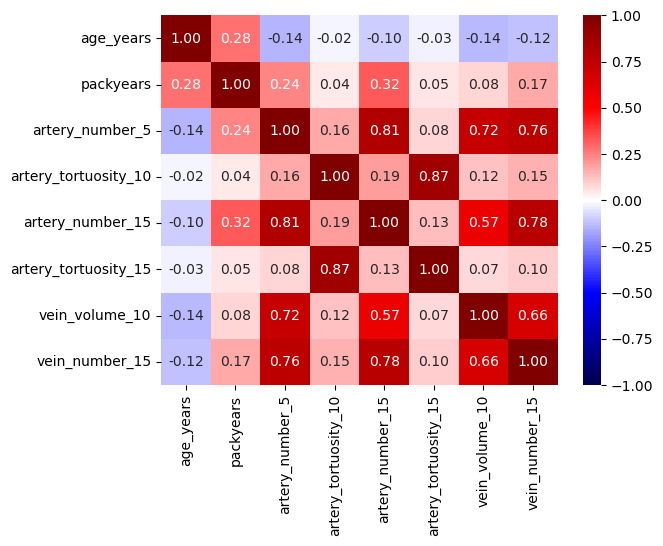

In [49]:
p = X.loc[:, model_dfns_remaining['Composite']].corr()
sns.heatmap(p, vmin=-1, vmax=1, cmap='seismic', annot=True, fmt='.2f')
plt.show()